**Import Libraries**

In [47]:
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

**Unzipping the Archive File**

In [34]:

# Path to the zip file and the extraction directory
zip_path = 'arch.zip'  # Adjust this if your zip file is in a different directory
extract_dir = 'extracted_data'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to {extract_dir}")

Extracted files to extracted_data


**Defining Parameters and Checking Data Directory**

In [35]:
# Parameters
img_size = (64, 64)  # Image size for the modelr
data_dir = os.path.join(extract_dir, 'leapGestRecog')  # Path to the folder containing gesture images

# Verify if the data directory exists
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"The directory {data_dir} does not exist. Please check the path.")


**Loading Images and Labels**

In [36]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label_folder in sorted(os.listdir(folder)):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for gesture_folder in sorted(os.listdir(label_path)):
                gesture_path = os.path.join(label_path, gesture_folder)
                if os.path.isdir(gesture_path):
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.resize(img, img_size)
                            images.append(img)
                            labels.append(gesture_folder)
    return images, labels

images, labels = load_images_from_folder(data_dir)
images = np.array(images) / 255.0  # Normalize pixel values
labels = np.array(labels)


**Encode Labels**

In [37]:
# Encode labels
unique_labels = np.unique(labels)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_labels = np.array([label_map[label] for label in labels])
y_labels = to_categorical(y_labels, num_classes=len(unique_labels))


**Split Dataset**

In [38]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, y_labels, test_size=0.2, stratify=y_labels)


**Data Augmentation**

In [39]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)


**Defining CNN Model**

In [48]:
# Define CNN model
model = Sequential([
    Input(shape=(64, 64, 3)),  # Specify the input shape using Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


**Training the Model**

In [49]:
# Train the model with data augmentation
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 129ms/step - accuracy: 0.3544 - loss: 1.7377 - val_accuracy: 0.9433 - val_loss: 0.2034
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 131ms/step - accuracy: 0.8295 - loss: 0.4938 - val_accuracy: 0.9465 - val_loss: 0.1271
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 140ms/step - accuracy: 0.9098 - loss: 0.2790 - val_accuracy: 0.9787 - val_loss: 0.0627
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.9376 - loss: 0.2004 - val_accuracy: 0.9895 - val_loss: 0.0378
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.9500 - loss: 0.1573 - val_accuracy: 0.9912 - val_loss: 0.0394
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.9537 - loss: 0.1411 - val_accuracy: 0.9975 - val_loss: 0.0136
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.9657 - loss: 0.1047 - val_accuracy: 0.9970 - val_loss: 0.0135
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 110ms/step - accuracy: 0.9701 - loss: 0.

**Evaluation of the Model**

In [42]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc * 100:.2f}%')


125/125 - 4s - 30ms/step - accuracy: 0.9985 - loss: 0.0096

Test accuracy: 99.85%


**Generation of Predictions**

In [43]:
# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


**Confusion Matrix**

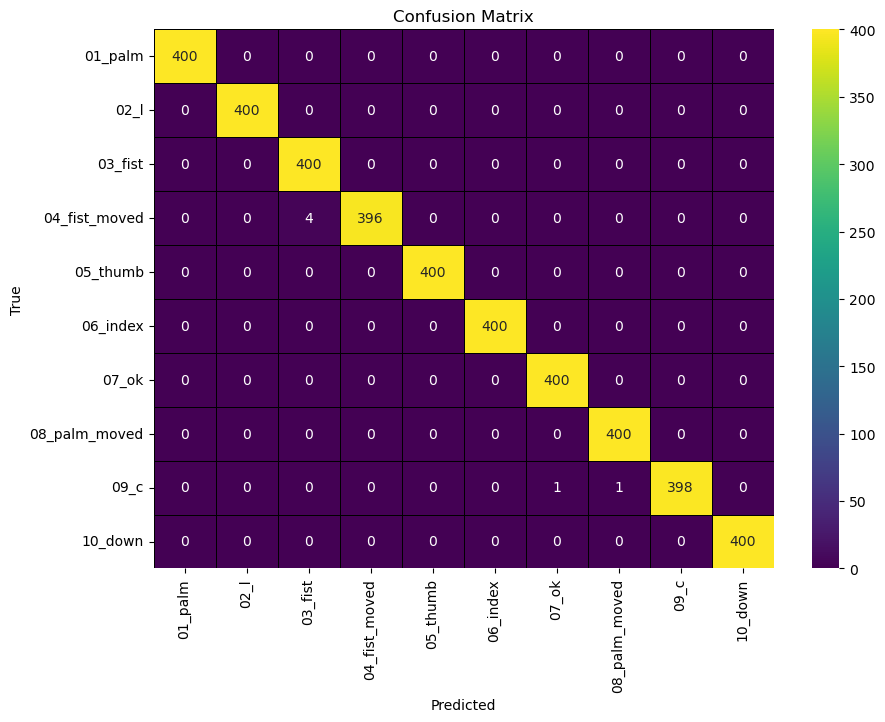

In [44]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a color palette for the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names,
                cbar=True, linewidths=0.5, linecolor='black')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, unique_labels)


**Classification Report**

In [45]:
# Classification report
print(classification_report(y_true, y_pred, target_names=unique_labels))


               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       400
         02_l       1.00      1.00      1.00       400
      03_fist       0.99      1.00      1.00       400
04_fist_moved       1.00      0.99      0.99       400
     05_thumb       1.00      1.00      1.00       400
     06_index       1.00      1.00      1.00       400
        07_ok       1.00      1.00      1.00       400
08_palm_moved       1.00      1.00      1.00       400
         09_c       1.00      0.99      1.00       400
      10_down       1.00      1.00      1.00       400

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



**Displaying Sample Predictions**

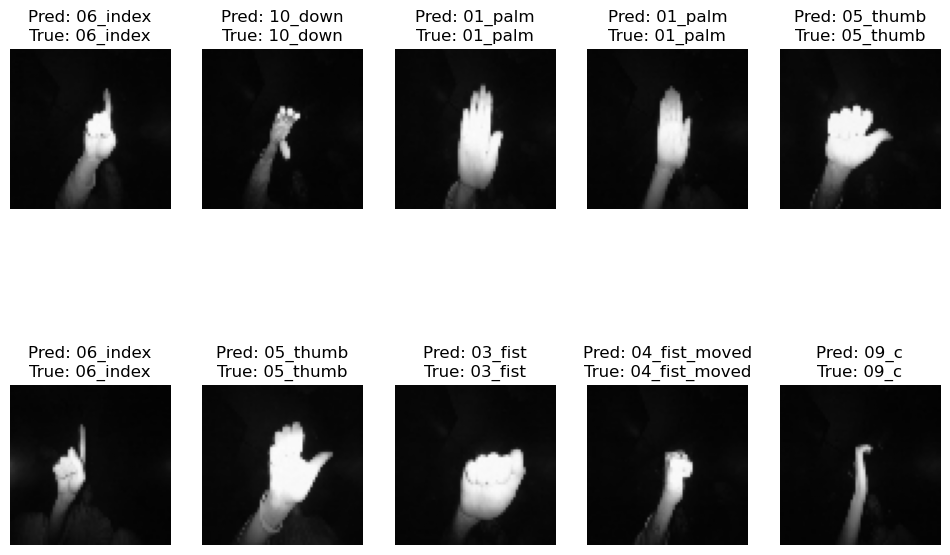

In [46]:
def plot_images(images, labels, predictions, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(10):  # Show 10 images
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

plot_images(X_test[:10], y_true[:10], y_pred, unique_labels)
